#Skin Cancer Detection
Contributer: Chih-Wei(Jerry) Huang, Louis Bemberg

This notebook implements convolutional neural networks to classify if a shown beauty spot on skin is malignant or benign melanocytic lesions.

The dataset is collected from Kaggle (https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign).

Project Proposal: [link](https://docs.google.com/document/d/1KhDiML04Nst33_4lCldjLdTuL1q9u2RygFfBFlxUTjE/edit)

Helpful reading of gradient descent optimization algorithms: [link](https://ruder.io/optimizing-gradient-descent/index.html#adam)

Understanding ReLU: [link](https://towardsdatascience.com/understanding-relu-the-most-popular-activation-function-in-5-minutes-459e3a2124f)

#Section 1: Environment Preparation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot as plt
from matplotlib.image import imread
from datetime import datetime

In [ ]:
# Enable a GPU accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr 26 00:40:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = plt.subplots(2, 1, figsize=(12,12))
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	plt.legend()
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.legend()
	plt.show()

The learning curves will be used in section 3 when analyzing our CNN models.

In [ ]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#Section 2: Data Preparation

We will dowonload the required dataset from our shared drive.

It is convenient and save your local disk room.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Machine_Learning_Workshop_2021_Capstone_Project/Code/Keras/skin_cancer/data/skin_cancer_malignant_benign.zip > unzip_output.txt

Plot some photos from the dataset for testing:



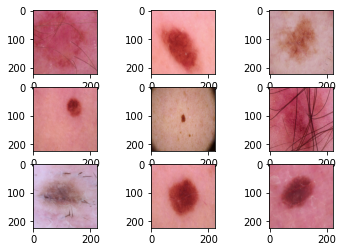

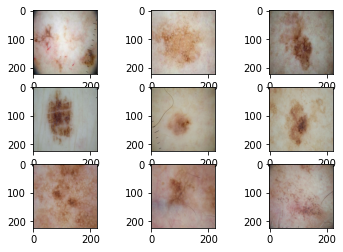

In [ ]:
# plot first few train bengin images
folder = 'data/train/benign/'
c = 0
for i in [3,4,6,7,12,13,14,17,19]:
    # define subplot
    plt.subplot(330 + 1 + c)
    # define filename
    filename = folder + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
    c += 1

plt.show()

# plot first few train malignant images
folder = 'data/train/malignant/'
c = 0
for i in [2,5,6,7,9,10,11,12,14]: 
    plt.subplot(330 + 1 + c)    
    filename = folder + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    c += 1
plt.show()

**Pre-Process Photos into Standard Directories:**

The API we are using for this project prefers the data to be organized into **train/** and **test/** directories.

The directories should be organized as below:
> data


*   train
  *   benign

  *   malignant


*   test
  *   benign

  *   malignant

Now we do not need any action since the folders are organized already.

#Section 3: Develop a Baseline Convolutional Neural Network(CNN) Model

A baseline model will be created first to show a minimum model performance that can be compared with other models with extra features. This model architecture will be used as the fundament of this project, and its parameters can be modified for further improvement.

**VGG- Network** is a convolutional neural network model proposed by K.Simonyan and A.Zisserman in the paper [“Very Deep Convolutional Networks for Large-Scale Image Recognition”](https://arxiv.org/abs/1409.1556). This architecture achieved top-5 test accuracy of 92.7% in ImageNet, which has over 14 million images belonging to 1000 classes.
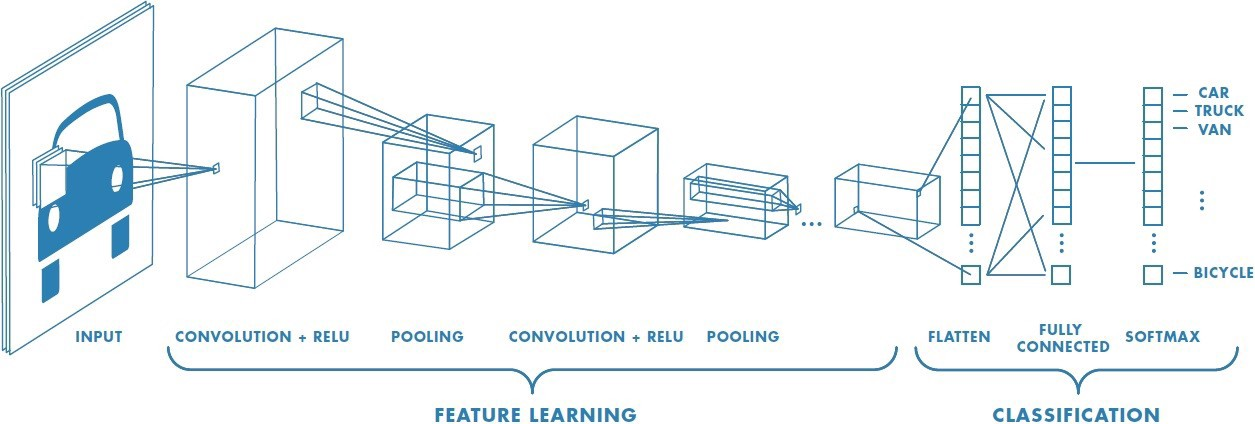

**Figure source**: [“Convolutional Neural Network by MathWorks”](https://www.mathworks.com/discovery/convolutional-neural-network-matlab.html)

The architecture involves stacking **convolutional 2D layers** with small 3×3 filters followed by a **max pooling 2D layer**. Combining the two, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. **Padding** is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.


The main purpose of the activation function is to introduce the property of non-linearity into the model.
**ReLU** stands for **rectified linear activation function**, and it is a commonly used activation function by default for performing a majority of the deep learning tasks.

In here, we use **Stochastic Gradient Descent(SGD)** to build the model, which performs a parameter update for each training. 

The **learning rate** determines the size of the steps we take to reach the target. The **momentum** is a method that helps accelerate SGD in the relevant direction and dampens oscillations. We are using a conservative learning rate of 0.001 and a usual momentum of 0.9. 

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 20s 229ms/step - loss: 0.8114 - accuracy: 0.5745 - val_loss: 0.6457 - val_accuracy: 0.5530
Epoch 2/50
42/42 [==============================] - 8s 201ms/step - loss: 0.6170 - accuracy: 0.6341 - val_loss: 0.5701 - val_accuracy: 0.7348
Epoch 3/50
42/42 [==============================] - 8s 200ms/step - loss: 0.5336 - accuracy: 0.7224 - val_loss: 0.4969 - val_accuracy: 0.7606
Epoch 4/50
42/42 [==============================] - 8s 198ms/step - loss: 0.5036 - accuracy: 0.7490 - val_loss: 0.6821 - val_accuracy: 0.6121
Epoch 5/50
42/42 [==============================] - 9s 204ms/step - loss: 0.5654 - accuracy: 0.7129 - val_loss: 0.4837 - val_accuracy: 0.7833
Epoch 6/50
42/42 [==============================] - 9s 204ms/step - loss: 0.4526 - accuracy: 0.7732 - val_loss: 0.4463 - val_accuracy: 0.7424
Epoch 7/50
42/42 [==============================] - 8s 200ms/ste

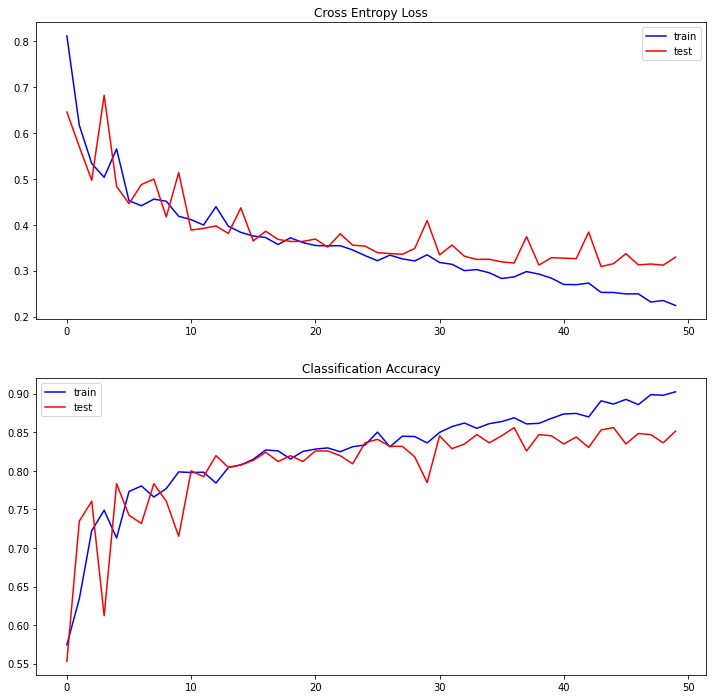

Total time for the model processing: 0:07:16.276944


In [ ]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	#compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

#evaluating the model
def run_test():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = datagen.flow_from_directory('data/train/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = datagen.flow_from_directory('data/test/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

# Section 4: Dropout regularization

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 9s 202ms/step - loss: 1.0089 - accuracy: 0.5408 - val_loss: 0.6757 - val_accuracy: 0.5485
Epoch 2/50
42/42 [==============================] - 8s 200ms/step - loss: 0.6478 - accuracy: 0.5954 - val_loss: 0.6330 - val_accuracy: 0.5803
Epoch 3/50
42/42 [==============================] - 8s 202ms/step - loss: 0.6099 - accuracy: 0.6739 - val_loss: 0.6047 - val_accuracy: 0.6682
Epoch 4/50
42/42 [==============================] - 8s 200ms/step - loss: 0.5845 - accuracy: 0.6962 - val_loss: 0.5875 - val_accuracy: 0.6333
Epoch 5/50
42/42 [==============================] - 8s 200ms/step - loss: 0.5525 - accuracy: 0.7266 - val_loss: 0.5696 - val_accuracy: 0.6424
Epoch 6/50
42/42 [==============================] - 8s 200ms/step - loss: 0.5456 - accuracy: 0.7224 - val_loss: 0.5389 - val_accuracy: 0.7394
Epoch 7/50
42/42 [==============================] - 8s 199ms/step

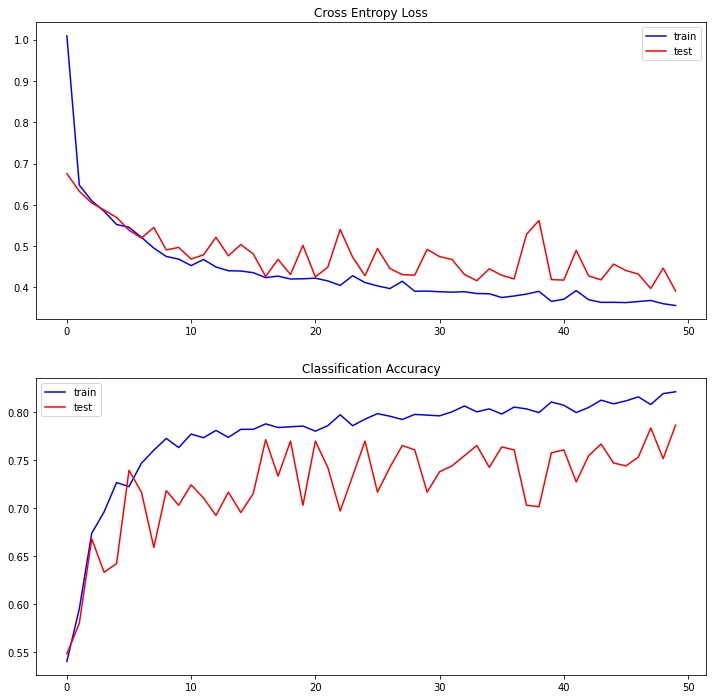

Total time for the model processing: 0:07:07.835693


In [ ]:
# baseline model with dropout regularization
startTimeModule = datetime.now()

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  #opt = Adam(learning_rate=0.001)
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#evaluating the model
def run_test():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = datagen.flow_from_directory('data/train/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = datagen.flow_from_directory('data/test/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

# Section 5: Image Data Augmentation

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 27s 640ms/step - loss: 1.5180 - accuracy: 0.6875 - val_loss: 0.4166 - val_accuracy: 0.7742
Epoch 2/50
42/42 [==============================] - 27s 635ms/step - loss: 0.4364 - accuracy: 0.7937 - val_loss: 0.3906 - val_accuracy: 0.8121
Epoch 3/50
42/42 [==============================] - 27s 632ms/step - loss: 0.3923 - accuracy: 0.8066 - val_loss: 0.3775 - val_accuracy: 0.8212
Epoch 4/50
42/42 [==============================] - 27s 634ms/step - loss: 0.3823 - accuracy: 0.8123 - val_loss: 0.3675 - val_accuracy: 0.8167
Epoch 5/50
42/42 [==============================] - 27s 635ms/step - loss: 0.3684 - accuracy: 0.8168 - val_loss: 0.4031 - val_accuracy: 0.7985
Epoch 6/50
42/42 [==============================] - 27s 630ms/step - loss: 0.3831 - accuracy: 0.8123 - val_loss: 0.4126 - val_accuracy: 0.8000
Epoch 7/50
42/42 [==============================] - 27s 634

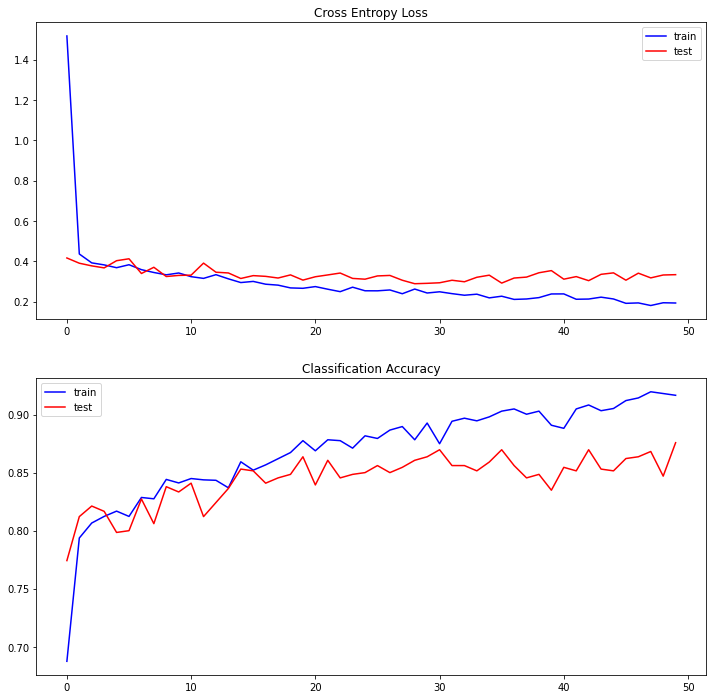

Total time for the model processing: 0:22:29.719324


In [ ]:
# baseline model with image data augmentation
startTimeModule = datetime.now()

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = Adam(learning_rate=0.001)
  #opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#evaluating the model
def run_test():
  # define model
  model = define_model()
  # create data generator
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    width_shift_range=0.1, rotation_range=30, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = train_datagen.flow_from_directory('data/train/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = test_datagen.flow_from_directory('data/test/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 27s 641ms/step - loss: 1.0913 - accuracy: 0.5722 - val_loss: 0.6279 - val_accuracy: 0.7167
Epoch 2/50
42/42 [==============================] - 27s 633ms/step - loss: 0.6285 - accuracy: 0.6435 - val_loss: 0.5849 - val_accuracy: 0.7348
Epoch 3/50
42/42 [==============================] - 27s 632ms/step - loss: 0.5874 - accuracy: 0.6928 - val_loss: 0.5657 - val_accuracy: 0.7485
Epoch 4/50
42/42 [==============================] - 27s 630ms/step - loss: 0.5487 - accuracy: 0.7372 - val_loss: 0.5024 - val_accuracy: 0.7167
Epoch 5/50
42/42 [==============================] - 26s 628ms/step - loss: 0.5207 - accuracy: 0.7342 - val_loss: 0.4798 - val_accuracy: 0.7848
Epoch 6/50
42/42 [==============================] - 26s 627ms/step - loss: 0.4848 - accuracy: 0.7603 - val_loss: 0.4336 - val_accuracy: 0.7818
Epoch 7/50
42/42 [==============================] - 27s 632

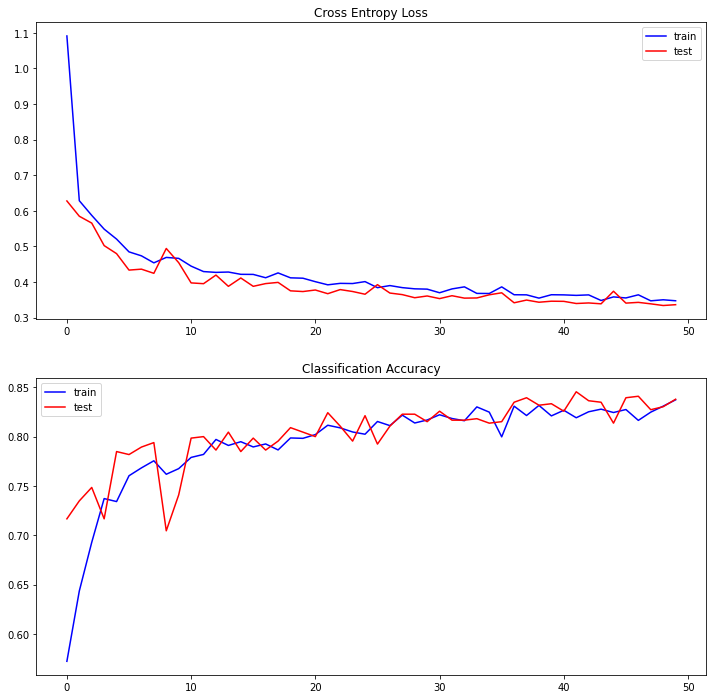

Total time for the model processing: 0:22:19.125912


In [ ]:
# Combination of dropout and image augmentation
startTimeModule = datetime.now()

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  #opt = Adam(learning_rate=0.001)
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# evaluating a model
def run_test():
  # define model
  model = define_model()
  # create data generator
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    width_shift_range=0.1, rotation_range=30, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = train_datagen.flow_from_directory('data/train/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = test_datagen.flow_from_directory('data/test/', color_mode='rgb',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)


run_test()
print('Total time for the model processing:', (datetime.now() - startTimeModule))